In [1]:
import glob
import numpy as np
import os
import h5py
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
def get_data_from_fof_folder(output_dir, snapN, param1, param2):
    snapdir = glob.glob(output_dir+f"groups_*{snapN}")[0]
    snap_files = os.listdir(snapdir)
    
    all_values = None

    for file_name in snap_files:
        file_path = snapdir+f"/{file_name}"

        with h5py.File(file_path, "r") as f:
            values_this_file = f[f'{param1}/{param2}'][:]
            
            if all_values is None:
                all_values = values_this_file
            else:
                all_values = np.concatenate((all_values, values_this_file))
            
    
    return all_values

def get_data_from_snap_folder(output_dir, snapN, param1, param2):
    snapdir = glob.glob(output_dir+f"snapdir_*{snapN}")[0]
    snap_files = os.listdir(snapdir)
    # print(snap_files)
    
    all_values = None

    for file_name in snap_files:
        # print("-------------- File begin ----------------")
        file_path = snapdir+f"/{file_name}"
        # print(file_path)

        with h5py.File(file_path, "r") as f:
            # header = f['Header']
            # for key, val in header.attrs.items():
                # print(f"{key}: {val}")
            values_this_file = f[f'{param1}/{param2}'][:]
            
            if all_values is None:
                all_values = values_this_file
            else:
                all_values = np.concatenate((all_values, values_this_file))
            
            # print(values_this_file.shape)
            # print(all_values.shape)
        
        # print("--------------- File end ------------------")
    
    return all_values

def get_data_from_header(output_dir, snapN, param='BoxSize'):

    snapdir = glob.glob(output_dir+f"snapdir_*{snapN}")[0]
    snap_files = os.listdir(snapdir)
    file_name = snap_files[0]
    file_path = snapdir+f"/{file_name}"

    with h5py.File(file_path, "r") as f:
        header = f['Header']
        return_param = header.attrs[param]
        
    return return_param


def simple_hist_plot_old(path, snapN, particle_type="PartType4", zoom_out_factor=1, resolution=128, mask_zeros=False):
    
    mask_zeros_value = 0.7 # set zero bins to this value, so that the log colorbar works
    
    coordinates = get_data_from_snap_folder(path, snapN, particle_type, "Coordinates")
    masses = get_data_from_snap_folder(path, snapN, particle_type, "Masses")*1e10 # in M_sun
    
    box_size = get_data_from_header(path, snapN, 'BoxSize')/1e3 # in Mpc
    physical_bin_volume = (box_size/resolution)**2 * box_size  # this is a projection, so one axis has the full length of the box
    
    ############# Zoom in Filter ###############
    
    subhalo_mass = get_data_from_fof_folder(path, snapN, "Subhalo", "SubhaloMass") * 1e10 # in M_sun
    M_milkyway = 1e12

    index_milkyway_like = min(range(len(subhalo_mass)), key=lambda i: abs(subhalo_mass[i] - M_milkyway))
    M_milkyway_like = subhalo_mass[index_milkyway_like]
    # print(index_milkyway_like, M_milkyway_like)

    subhalo_cms = get_data_from_fof_folder(path, snapN, "Subhalo", "SubhaloCM")
    # print(subhalo_cms[index_milkyway_like])

    subhalo_hmr = get_data_from_fof_folder(path, snapN, "Subhalo", "SubhaloHalfmassRad")
    # print(subhalo_hmr[index_milkyway_like])
    
    zoom_in_x = [subhalo_cms[index_milkyway_like][0] - (subhalo_hmr[index_milkyway_like]*zoom_out_factor), 
                 subhalo_cms[index_milkyway_like][0] + (subhalo_hmr[index_milkyway_like]*zoom_out_factor)]
    zoom_in_y = [subhalo_cms[index_milkyway_like][1] - (subhalo_hmr[index_milkyway_like]*zoom_out_factor), 
                 subhalo_cms[index_milkyway_like][1] + (subhalo_hmr[index_milkyway_like]*zoom_out_factor)]
    zoom_in_z = [subhalo_cms[index_milkyway_like][2] - (subhalo_hmr[index_milkyway_like]*zoom_out_factor), 
                 subhalo_cms[index_milkyway_like][2] + (subhalo_hmr[index_milkyway_like]*zoom_out_factor)]

    
    masses = masses[coordinates[:, 0] < zoom_in_x[1]]
    coordinates = coordinates[coordinates[:, 0] < zoom_in_x[1]]
    
    masses = masses[coordinates[:, 0] > zoom_in_x[0]]
    coordinates = coordinates[coordinates[:, 0] > zoom_in_x[0]]
    
    masses = masses[coordinates[:, 1] < zoom_in_y[1]]
    coordinates = coordinates[coordinates[:, 1] < zoom_in_y[1]]
    
    masses = masses[coordinates[:, 1] > zoom_in_y[0]]
    coordinates = coordinates[coordinates[:, 1] > zoom_in_y[0]]
    
    masses = masses[coordinates[:, 2] < zoom_in_z[1]]
    coordinates = coordinates[coordinates[:, 2] < zoom_in_z[1]]
    
    masses = masses[coordinates[:, 2] > zoom_in_z[0]]
    coordinates = coordinates[coordinates[:, 2] > zoom_in_z[0]]

    ############################################
    
    # calculate the hist
    h, xedges, yedges = np.histogram2d(coordinates[:, 0], coordinates[:, 1], weights=masses, bins=resolution)
    
    if mask_zeros:
        h[h == 0] = mask_zeros_value
        norm = mpl.colors.LogNorm(vmin=h.min(), vmax=h.max())
    else:
        norm = mpl.colors.LogNorm(vmax=h.max())

    # plot
    fig, ax = plt.subplots(dpi=150)
    img = ax.imshow(h.T, origin='lower', cmap='magma',
                    extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
                    norm=norm, interpolation='nearest')

    cbar = plt.colorbar(img, ax=ax)
    
    # make colorbar nice
    ticks = cbar.get_ticks()
    new_labels = [f"{tick/physical_bin_volume:.1e}" for tick in ticks]
    cbar.set_ticks(ticks)
    cbar.set_ticklabels(new_labels)
    cbar.set_label(r"Density [$M_\odot$/$Mpc^3$]")
    
    ax.set_facecolor('black')
    
    ax.set_xlabel('x [ckpc/h]')
    ax.set_ylabel('y [ckpc/h]')
    ax.set_title('2D Projection Histrogramm')
    plt.show()

In [4]:
path = "/vera/u/jerbo/my_ptmp/L25n128_suite/gridpoint0/"
snapN = 5

subhalo_mass = get_data_from_fof_folder(path, snapN, "Subhalo", "SubhaloMass") * 1e10 # in M_sun
M_milkyway = 1.2e12

index_milkyway_like = min(range(len(subhalo_mass)), key=lambda i: abs(subhalo_mass[i] - M_milkyway))
M_milkyway_like = subhalo_mass[index_milkyway_like]
print(index_milkyway_like, M_milkyway_like)

subhalo_cms = get_data_from_fof_folder(path, snapN, "Subhalo", "SubhaloCM")
print(subhalo_cms[index_milkyway_like])

subhalo_hmr = get_data_from_fof_folder(path, snapN, "Subhalo", "SubhaloHalfmassRad")
print(subhalo_hmr[index_milkyway_like])

box_size = get_data_from_header(path, snapN, 'BoxSize')/1e3 # in Mpc

1421 1198788000000.0
[10942.941 13435.836 20800.273]
68.10001


In [4]:
coordinates = get_data_from_snap_folder(path, snapN, "PartType4", "Coordinates")
print(coordinates)

[[ 5276.7512408   6867.02899727 18244.47239739]
 [ 5276.55147955  6866.22564064 18243.32950616]
 [ 5276.88780443  6865.25346881 18242.06320957]
 ...
 [11730.87208332  9073.66574572 18037.21361499]
 [11628.88014859  9045.46476652 18180.0746915 ]
 [11789.42468984  9132.22325445 18016.25570373]]


In [5]:
zoom_out_factor = 10
zoom_in_x = [subhalo_cms[index_milkyway_like][0] - (subhalo_hmr[index_milkyway_like]*zoom_out_factor), 
             subhalo_cms[index_milkyway_like][0] + (subhalo_hmr[index_milkyway_like]*zoom_out_factor)]
zoom_in_y = [subhalo_cms[index_milkyway_like][1] - (subhalo_hmr[index_milkyway_like]*zoom_out_factor), 
             subhalo_cms[index_milkyway_like][1] + (subhalo_hmr[index_milkyway_like]*zoom_out_factor)]
zoom_in_z = [subhalo_cms[index_milkyway_like][2] - (subhalo_hmr[index_milkyway_like]*zoom_out_factor), 
             subhalo_cms[index_milkyway_like][2] + (subhalo_hmr[index_milkyway_like]*zoom_out_factor)]

print(box_size*1e3)

25000.0


In [6]:
print(coordinates.shape)
print(coordinates)
coordinates = coordinates[coordinates[:, 0] < zoom_in_x[1]]
coordinates = coordinates[coordinates[:, 0] > zoom_in_x[0]]
coordinates = coordinates[coordinates[:, 1] < zoom_in_y[1]]
coordinates = coordinates[coordinates[:, 1] > zoom_in_y[0]]
coordinates = coordinates[coordinates[:, 2] < zoom_in_z[1]]
coordinates = coordinates[coordinates[:, 2] > zoom_in_z[0]]
print(coordinates.shape)
print(coordinates[:10])

(33725, 3)
[[ 5276.7512408   6867.02899727 18244.47239739]
 [ 5276.55147955  6866.22564064 18243.32950616]
 [ 5276.88780443  6865.25346881 18242.06320957]
 ...
 [11730.87208332  9073.66574572 18037.21361499]
 [11628.88014859  9045.46476652 18180.0746915 ]
 [11789.42468984  9132.22325445 18016.25570373]]
(123, 3)
[[10940.22862078 13445.49782152 20799.37924558]
 [10938.58586508 13445.30864124 20799.44038565]
 [10939.04175835 13445.77172414 20799.68180391]
 [10939.28224939 13445.57734014 20799.16249462]
 [10939.09464133 13447.08599143 20799.06207272]
 [10938.67723731 13445.65140716 20801.4110301 ]
 [10939.92875618 13445.78348073 20800.35695711]
 [10939.96298174 13445.58595297 20800.10364709]
 [10939.80987493 13445.56977664 20800.18467463]
 [10940.87844582 13446.2468142  20800.69212889]]


In [7]:
print(get_data_from_header(path, snapN, 'MassTable'))

[0.         0.06637263 0.         0.01168241 0.         0.        ]


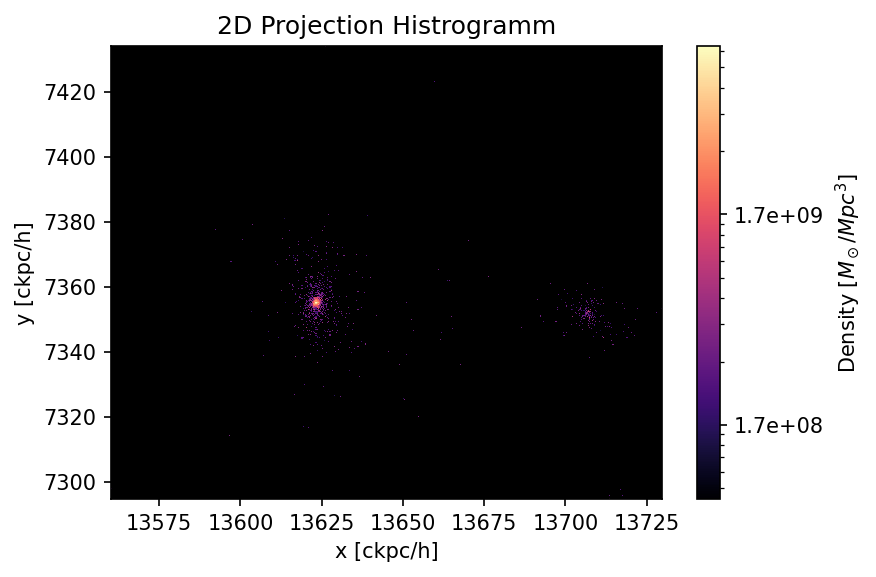

In [8]:
path = "/vera/u/jerbo/my_ptmp/L25n256_suite/gridpoint25/"
simple_hist_plot_old(path, 5, particle_type="PartType4", resolution=512, zoom_out_factor=1)

In [9]:
# print(sorted(subhalo_mass, reverse=True))

In [3]:
def subhalo_projection(path, snapN, particle_type="PartType4", zomm_in_box_size=500, look_for_centeral_bh_radius=500):
    subhalo_mass = get_data_from_fof_folder(path, snapN, "Subhalo", "SubhaloMass") * 1e10 # in M_sun

    index_biggeset_halo = max(range(len(subhalo_mass)), key=lambda i: subhalo_mass[i])
    bigges_subhalo = subhalo_mass[index_biggeset_halo]

    subhalo_cms = get_data_from_fof_folder(path, snapN, "Subhalo", "SubhaloCM")
    biggest_subhalo_cms = subhalo_cms[index_biggeset_halo]
    
    centeral_galaxy_bh = find_centeral_bh(path, snapN, biggest_subhalo_cms, look_for_centeral_bh_radius)

    boxsize = get_data_from_header(path, snapN, 'BoxSize') # in kpc
    
    # transform coordinates to center biggest_halo_cms
    coordinates = get_data_from_snap_folder(path, snapN, particle_type, "Coordinates")
    masses = get_data_from_snap_folder(path, snapN, particle_type, "Masses")*1e10 # in M_sun

    # transform to periodic coordinates centered around centeral_galaxy_bh
    cms_center_coordinates = coordinates - centeral_galaxy_bh
    cms_center_coordinates = (cms_center_coordinates + boxsize / 2) % boxsize - boxsize / 2
    
    masses = masses[cms_center_coordinates[:, 0] < zomm_in_box_size]
    cms_center_coordinates = cms_center_coordinates[cms_center_coordinates[:, 0] < zomm_in_box_size]
    masses = masses[cms_center_coordinates[:, 0] > -zomm_in_box_size]
    cms_center_coordinates = cms_center_coordinates[cms_center_coordinates[:, 0] > -zomm_in_box_size]
    masses = masses[cms_center_coordinates[:, 1] < zomm_in_box_size]
    cms_center_coordinates = cms_center_coordinates[cms_center_coordinates[:, 1] < zomm_in_box_size]
    masses = masses[cms_center_coordinates[:, 1] > -zomm_in_box_size]
    cms_center_coordinates = cms_center_coordinates[cms_center_coordinates[:, 1] > -zomm_in_box_size]
    masses = masses[cms_center_coordinates[:, 2] < zomm_in_box_size]
    cms_center_coordinates = cms_center_coordinates[cms_center_coordinates[:, 2] < zomm_in_box_size]
    masses = masses[cms_center_coordinates[:, 2] > -zomm_in_box_size]
    cms_center_coordinates = cms_center_coordinates[cms_center_coordinates[:, 2] > -zomm_in_box_size]
    
    
    return cms_center_coordinates, masses

In [4]:
def find_centeral_bh(path, snapN, zoom_in_box_middle, zoom_in_box_size):
    particle_type = "PartType5"
    coordinates = get_data_from_snap_folder(path, snapN, particle_type, "Coordinates")
    boxsize = get_data_from_header(path, snapN, 'BoxSize') # in kpc
    
    # transform into periodic box with center at zoom_in_box_middle
    center_coordinates = (coordinates - zoom_in_box_middle + boxsize / 2) % boxsize - boxsize / 2
    
    # only look at objects within a box centered around 0 with zoom_in_box_size as length, heigt and width 
    center_coordinates = center_coordinates[center_coordinates[:, 0] < zoom_in_box_size]
    center_coordinates = center_coordinates[center_coordinates[:, 0] > -zoom_in_box_size]
    center_coordinates = center_coordinates[center_coordinates[:, 1] < zoom_in_box_size]
    center_coordinates = center_coordinates[center_coordinates[:, 1] > -zoom_in_box_size]
    center_coordinates = center_coordinates[center_coordinates[:, 2] < zoom_in_box_size]
    center_coordinates = center_coordinates[center_coordinates[:, 2] > -zoom_in_box_size]
    
    # center_coordinates is ordered by mass, so center_coordinates[0] is the most massive BH in the box
    # then transform back to original coordinates
    centeral_bh_coords = (center_coordinates[0] + zoom_in_box_middle + boxsize / 2) % boxsize - boxsize / 2
    
    return centeral_bh_coords

In [14]:
path = "/vera/u/jerbo/my_ptmp/L25n256_suite/gridpoint0/"
snapN = 5
particle_type = "PartType4"
resolution = 256

subhalo_mass = get_data_from_fof_folder(path, snapN, "Subhalo", "SubhaloMass") * 1e10 # in M_sun

index_biggeset_halo = max(range(len(subhalo_mass)), key=lambda i: subhalo_mass[i])
bigges_subhalo = subhalo_mass[index_milkyway_like]
print(index_biggeset_halo, bigges_subhalo)

subhalo_cms = get_data_from_fof_folder(path, snapN, "Subhalo", "SubhaloCM")
biggest_subhalo_cms = subhalo_cms[index_biggeset_halo]
print(biggest_subhalo_cms)

centeral_galaxy_bh = find_centeral_bh(path, snapN, biggest_subhalo_cms, 500)

boxsize = get_data_from_header(path, snapN, 'BoxSize') # in kpc

6242 24768657000.0
[17480.715   336.586 19364.4  ]


In [15]:
# transform coordinates to center biggest_halo_cms
coordinates = get_data_from_snap_folder(path, snapN, particle_type, "Coordinates")
masses = get_data_from_snap_folder(path, snapN, particle_type, "Masses")*1e10 # in M_sun

box_size = get_data_from_header(path, snapN, 'BoxSize')/1e3 # in Mpc
physical_bin_volume = (box_size/resolution)**2 * box_size  # this is a projection, so one axis has the full length of the box

############# Zoom in Filter ###############
print(coordinates)
cms_center_coordinates = coordinates - centeral_galaxy_bh
print(cms_center_coordinates)
cms_center_coordinates = (cms_center_coordinates + boxsize / 2) % boxsize - boxsize / 2
cms_center_point = np.array([0, 0, 0])
print(cms_center_coordinates)

[[11672.61142801  9087.35462319 18030.13163048]
 [11784.06031127  9131.6533439  18042.64107008]
 [11799.09136505  9104.80671368 18049.09703516]
 ...
 [ 8407.40463154  2169.99465979 18508.23145767]
 [ 8409.42495156  2169.6845408  18508.43291243]
 [ 8408.20975586  2170.14779132 18507.42554992]]
[[19243.45347073  8695.90083649 23662.10471005]
 [19354.90235398  8740.1995572  23674.61414965]
 [19369.93340776  8713.35292698 23681.07011474]
 ...
 [15978.24667425  1778.54087309 24140.20453725]
 [15980.26699427  1778.2307541  24140.405992  ]
 [15979.05179857  1778.69400462 24139.3986295 ]]
[[-5756.54652927  8695.90083649 -1337.89528995]
 [-5645.09764602  8740.1995572  -1325.38585035]
 [-5630.06659224  8713.35292698 -1318.92988526]
 ...
 [-9021.75332575  1778.54087309  -859.79546275]
 [-9019.73300573  1778.2307541   -859.594008  ]
 [-9020.94820143  1778.69400462  -860.6013705 ]]


In [16]:
zomm_in_box_size = 500

masses = masses[cms_center_coordinates[:, 0] < zomm_in_box_size]
cms_center_coordinates = cms_center_coordinates[cms_center_coordinates[:, 0] < zomm_in_box_size]
masses = masses[cms_center_coordinates[:, 0] > -zomm_in_box_size]
cms_center_coordinates = cms_center_coordinates[cms_center_coordinates[:, 0] > -zomm_in_box_size]
masses = masses[cms_center_coordinates[:, 1] < zomm_in_box_size]
cms_center_coordinates = cms_center_coordinates[cms_center_coordinates[:, 1] < zomm_in_box_size]
masses = masses[cms_center_coordinates[:, 1] > -zomm_in_box_size]
cms_center_coordinates = cms_center_coordinates[cms_center_coordinates[:, 1] > -zomm_in_box_size]
masses = masses[cms_center_coordinates[:, 2] < zomm_in_box_size]
cms_center_coordinates = cms_center_coordinates[cms_center_coordinates[:, 2] < zomm_in_box_size]
masses = masses[cms_center_coordinates[:, 2] > -zomm_in_box_size]
cms_center_coordinates = cms_center_coordinates[cms_center_coordinates[:, 2] > -zomm_in_box_size]

In [17]:
cms_stars = np.sum(cms_center_coordinates*masses[:, np.newaxis], axis=0)/np.sum(masses)
print(cms_stars)

[ 73.54692712 -59.50108646 -60.38680777]


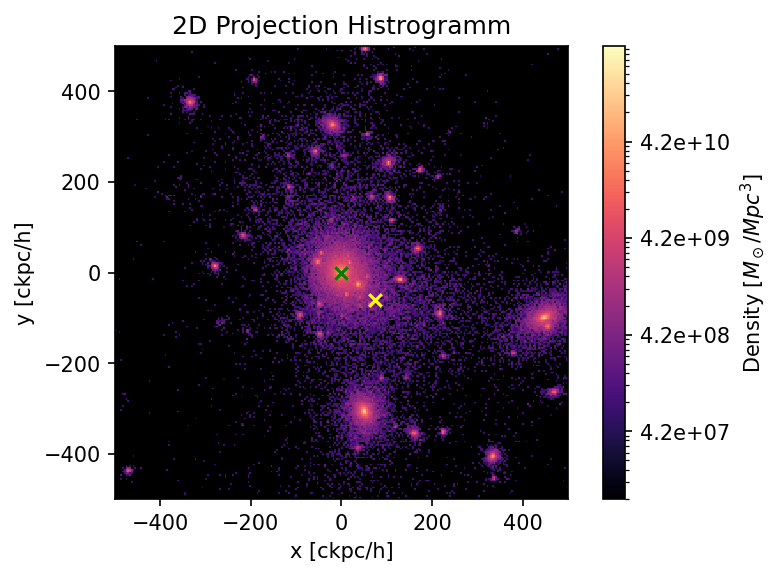

In [18]:
# calculate the hist
h, xedges, yedges = np.histogram2d(cms_center_coordinates[:, 0], cms_center_coordinates[:, 1], weights=masses, bins=resolution)

norm = mpl.colors.LogNorm(vmax=h.max())

# plot
fig, ax = plt.subplots(dpi=150)
img = ax.imshow(h.T, origin='lower', cmap='magma',
                extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
                norm=norm, interpolation='nearest')

ax.scatter(cms_center_point[0], cms_center_point[1], c="green", marker="x")
ax.scatter(cms_stars[0], cms_stars[1], c="yellow", marker="x")
# ax.scatter(centeral_galaxy_bh[0], centeral_galaxy_bh[1], c="blue", marker="x")

cbar = plt.colorbar(img, ax=ax)

# make colorbar nice
ticks = cbar.get_ticks()
new_labels = [f"{tick/physical_bin_volume:.1e}" for tick in ticks]
cbar.set_ticks(ticks)
cbar.set_ticklabels(new_labels)
cbar.set_label(r"Density [$M_\odot$/$Mpc^3$]")

ax.set_facecolor('black')

ax.set_xlabel('x [ckpc/h]')
ax.set_ylabel('y [ckpc/h]')
ax.set_title('2D Projection Histrogramm')
plt.show()

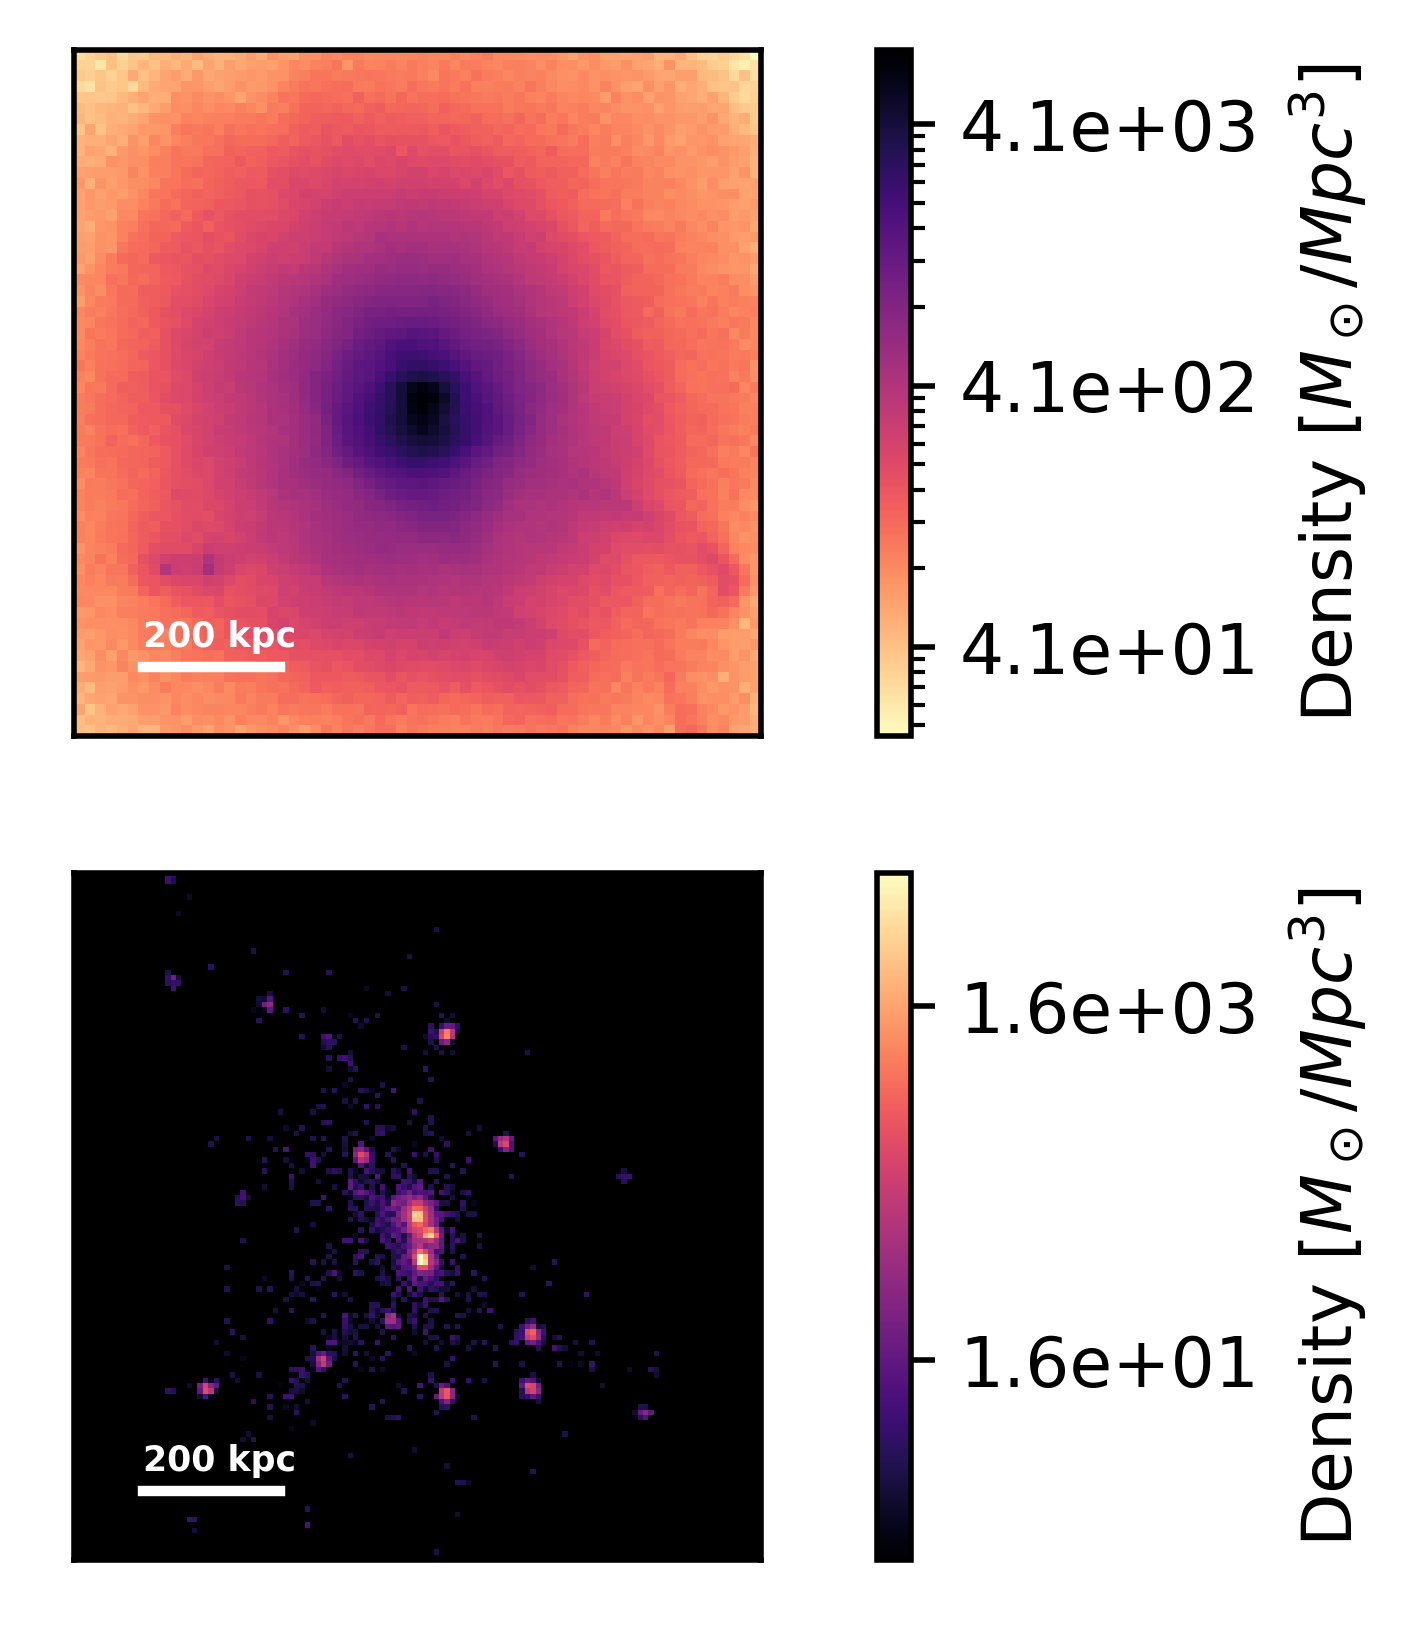

In [16]:
path = "/vera/u/jerbo/my_ptmp/L25n256_suite/gridpoint7/"
snapN = 5
gas_resolution=64
stars_resolution = 128
zoom_box_size = 1000
ref_line_length = 200


zoom_box_half = zoom_box_size/2

coordinates_stars, masses_stars = subhalo_projection(path, snapN, particle_type="PartType4", zomm_in_box_size=zoom_box_half,
                                         look_for_centeral_bh_radius=300)

coordinates_gas, masses_gas = subhalo_projection(path, snapN, particle_type="PartType0", zomm_in_box_size=zoom_box_half,
                                         look_for_centeral_bh_radius=300)

# calculate the hist
h_gas, xedges_gas, yedges_gas = np.histogram2d(coordinates_gas[:, 0], coordinates_gas[:, 1], weights=masses_gas, bins=gas_resolution, range=[[-zoom_box_half, zoom_box_half], [-zoom_box_half, zoom_box_half]])
h_stars, xedges_stars, yedges_stars = np.histogram2d(coordinates_stars[:, 0], coordinates_stars[:, 1], weights=masses_stars, bins=stars_resolution, range=[[-zoom_box_half, zoom_box_half], [-zoom_box_half, zoom_box_half]])



# plot
fig, ax = plt.subplots(nrows=2, ncols=1, dpi=500)

# gas
norm_gas = mpl.colors.LogNorm(vmax=h_gas.max())
img_gas = ax[0].imshow(h_gas.T, origin='lower', cmap='magma_r',
                extent=[xedges_gas[0], xedges_gas[-1], yedges_gas[0], yedges_gas[-1]],
                    norm=norm_gas, interpolation='nearest')

ref_line = np.array([[-zoom_box_half*0.8, -zoom_box_half*0.8 + ref_line_length], [-zoom_box_half*0.8, -zoom_box_half*0.8]])
ax[0].plot(ref_line[0], ref_line[1], c="white")
ax[0].text(ref_line[0][0], ref_line[1][0]*0.95, fr"{ref_line_length} kpc", va='bottom', fontsize=5, color="white", weight='bold')

# Colorbar
cbar_gas = plt.colorbar(img_gas, ax=ax[0])
ticks_gas = cbar_gas.get_ticks()
physical_bin_volume_gas = (zoom_box_size/gas_resolution)**2 * zoom_box_size  # this is a projection, so one axis has the full length of the box
new_labels_gas = [f"{ticks_gas/physical_bin_volume_gas:.1e}" for ticks_gas in ticks_gas]
cbar_gas.set_ticks(ticks_gas)
cbar_gas.set_ticklabels(new_labels_gas)
cbar_gas.set_label(r"Density [$M_\odot$/$Mpc^3$]")

ax[0].set_facecolor('black')

ax[0].get_xaxis().set_visible(False)
ax[0].get_yaxis().set_visible(False)

# stars
norm_stars = mpl.colors.LogNorm(vmax=h_stars.max())
img_stars = ax[1].imshow(h_stars.T, origin='lower', cmap='magma',
                extent=[xedges_stars[0], xedges_stars[-1], yedges_stars[0], yedges_stars[-1]],
                      norm=norm_stars, interpolation='nearest')

ref_line = np.array([[-zoom_box_half*0.8, -zoom_box_half*0.8 + ref_line_length], [-zoom_box_half*0.8, -zoom_box_half*0.8]])
ax[1].plot(ref_line[0], ref_line[1], c="white")
ax[1].text(ref_line[0][0], ref_line[1][0]*0.95, fr"{ref_line_length} kpc", va='bottom', fontsize=5, color="white", weight='bold')

# Colorbar
cbar_stars = plt.colorbar(img_stars, ax=ax[1])
ticks_stars = cbar_stars.get_ticks()
physical_bin_volume_stars = (zoom_box_size/stars_resolution)**2 * zoom_box_size  # this is a projection, so one axis has the full length of the box
new_labels_stars = [f"{ticks_stars/physical_bin_volume_stars:.1e}" for ticks_stars in ticks_stars]
cbar_stars.set_ticks(ticks_stars)
cbar_stars.set_ticklabels(new_labels_stars)
cbar_stars.set_label(r"Density [$M_\odot$/$Mpc^3$]")

ax[1].set_facecolor('black')

ax[1].get_xaxis().set_visible(False)
ax[1].get_yaxis().set_visible(False)

plt.savefig("plots/test_galaxy_show.pdf", format="PDF")
plt.show()

In [ ]:
print(xedges_stars[0], xedges_stars[-1], yedges_stars[0], yedges_stars[-1])

-364.6859613721681 351.0905249179923 -484.4612016324172 497.13494247642666


In [5]:
def get_cosmo_parameters(basepath):
    path = basepath+"txt-files/parameters-usedvalues"
    Omega0 = None
    OmegaLambda = None
    HubbleParam = None
    OmegaBaryon = None
    
    with open(path, "r") as f:
        for line in f:
            if "Omega0" in line:
                Omega0 = float(line.split()[-1])
            if "OmegaBaryon" in line:
                OmegaBaryon = float(line.split()[-1])
            if "OmegaLambda" in line:
                OmegaLambda = float(line.split()[-1])
            if "HubbleParam" in line:
                HubbleParam = float(line.split()[-1])
    
    return Omega0, OmegaBaryon, OmegaLambda, HubbleParam

gp 0 calcs...
gp 1 calcs...
gp 2 calcs...
gp 3 calcs...
gp 4 calcs...
gp 5 calcs...
gp 6 calcs...
gp 7 calcs...
gp 8 calcs...
gp 9 calcs...
gp 10 calcs...
gp 11 calcs...
gp 12 calcs...
gp 13 calcs...
/vera/u/jerbo/my_ptmp/L25n256_suite/gridpoint1/output/
/vera/u/jerbo/my_ptmp/L25n256_suite/gridpoint2/output/
/vera/u/jerbo/my_ptmp/L25n256_suite/gridpoint3/output/
/vera/u/jerbo/my_ptmp/L25n256_suite/gridpoint4/output/
/vera/u/jerbo/my_ptmp/L25n256_suite/gridpoint5/output/
/vera/u/jerbo/my_ptmp/L25n256_suite/gridpoint6/output/
/vera/u/jerbo/my_ptmp/L25n256_suite/gridpoint7/output/
/vera/u/jerbo/my_ptmp/L25n256_suite/gridpoint8/output/
/vera/u/jerbo/my_ptmp/L25n256_suite/gridpoint9/output/
/vera/u/jerbo/my_ptmp/L25n256_suite/gridpoint10/output/
/vera/u/jerbo/my_ptmp/L25n256_suite/gridpoint11/output/
/vera/u/jerbo/my_ptmp/L25n256_suite/gridpoint12/output/
/vera/u/jerbo/my_ptmp/L25n256_suite/gridpoint13/output/
/vera/u/jerbo/my_ptmp/L25n256_suite/gridpoint14/output/


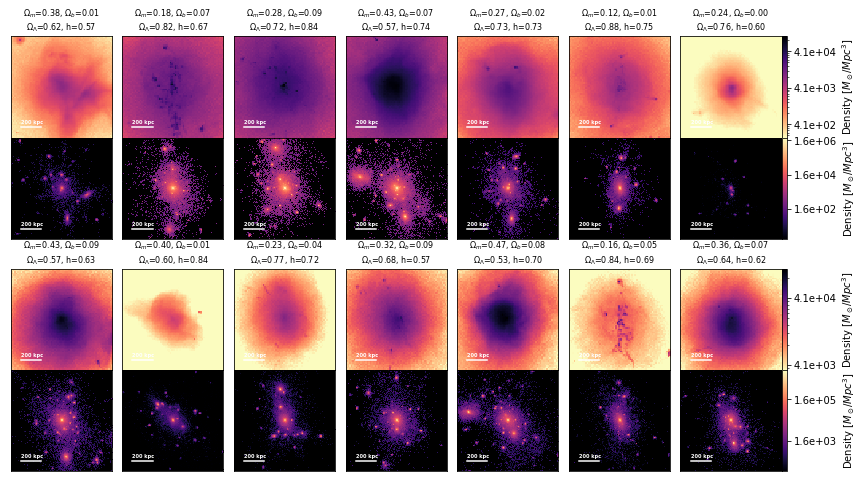

In [6]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

base_path = "/vera/u/jerbo/my_ptmp/L25n256_suite/"
snapN = 5
gas_resolution=64
stars_resolution = 128
zoom_box_size = 1000
ref_line_length = 200

gps_to_use = [i for i in range(1, 15)]
n_cols = 7
n_rows = 2

zoom_box_half = zoom_box_size/2

# get coords and masses for all boxes
star_hists = []
gas_hists = []
for gp_counter in range(n_cols*n_rows):
    print(f"gp {gp_counter} calcs...")
    path_gp = base_path + f"gridpoint{gps_to_use[gp_counter]}/output/"
    
    cs_temp, ms_temp = subhalo_projection(path_gp, snapN, particle_type="PartType4", zomm_in_box_size=zoom_box_half,
                                         look_for_centeral_bh_radius=300)
    cg_temp, mg_temp = subhalo_projection(path_gp, snapN, particle_type="PartType0", zomm_in_box_size=zoom_box_half,
                                             look_for_centeral_bh_radius=300)
    
    h_stars, xedges_stars, yedges_stars = np.histogram2d(cs_temp[:, 0], cs_temp[:, 1], weights=ms_temp, bins=stars_resolution, range=[[-zoom_box_half, zoom_box_half], [-zoom_box_half, zoom_box_half]])
    
    h_gas, xedges_gas, yedges_gas = np.histogram2d(cg_temp[:, 0], cg_temp[:, 1], weights=mg_temp, bins=gas_resolution, range=[[-zoom_box_half, zoom_box_half], [-zoom_box_half, zoom_box_half]])
    
    star_hists.append(h_stars)
    gas_hists.append(h_gas)
    
max_star_norm_1 = max([i.max() for i in star_hists[:n_cols]])
max_gas_norm_1 = max([i.max() for i in gas_hists[:n_cols]])

norm_stars_1 = mpl.colors.LogNorm(vmax=max_star_norm_1)
norm_gas_1 = mpl.colors.LogNorm(vmax=max_gas_norm_1)

max_star_norm_2 = max([i.max() for i in star_hists[n_cols:]])
max_gas_norm_2 = max([i.max() for i in gas_hists[n_cols:]])

norm_stars_2 = mpl.colors.LogNorm(vmax=max_star_norm_2)
norm_gas_2 = mpl.colors.LogNorm(vmax=max_gas_norm_2)


fig = plt.figure(figsize=(14, 8))

# Gesamtes Grid: 2 Blöcke (je 2 Reihen) × 5 Spalten
outer = gridspec.GridSpec(n_rows, 1, hspace=0.15)  # Abstand zwischen Block1 & Block2

# Block 1: Reihe 1 & 2 ohne Abstand
block1 = gridspec.GridSpecFromSubplotSpec(2, n_cols, subplot_spec=outer[0], hspace=0, wspace=0)
gp_counter = 0
for i in range(n_cols):
    ax_gas = fig.add_subplot(block1[0, i])
    ax_stars = fig.add_subplot(block1[1, i])
    
    path_gp = base_path + f"gridpoint{gps_to_use[gp_counter]}/output/"
    print(path_gp)
    Omega0, OmegaBaryon, OmegaLambda, HubbleParam = get_cosmo_parameters(path_gp)

    # calculate the hist
    h_gas = gas_hists[gp_counter]
    h_stars = star_hists[gp_counter]
    
    # gas
    
    img_gas = ax_gas.imshow(h_gas.T, origin='lower', cmap='magma_r',
                    extent=[-zoom_box_half, zoom_box_half, -zoom_box_half, zoom_box_half],
                        norm=norm_gas_1, interpolation='nearest')

    ref_line = np.array([[-zoom_box_half*0.8, -zoom_box_half*0.8 + ref_line_length], [-zoom_box_half*0.8, -zoom_box_half*0.8]])
    ax_gas.plot(ref_line[0], ref_line[1], c="white")
    ax_gas.text(ref_line[0][0], ref_line[1][0]*0.95, fr"{ref_line_length} kpc", va='bottom', fontsize=5, color="white", weight='bold')
    
    if i == n_cols-1:
        # Colorbar
        cbar_gas = fig.colorbar(img_gas, ax=ax_gas, fraction=0.046, pad=0)
        ticks_gas = cbar_gas.get_ticks()
        physical_bin_volume_gas = (zoom_box_size/gas_resolution)**2 * zoom_box_size  # this is a projection, so one axis has the full length of the box
        new_labels_gas = [f"{ticks_gas/physical_bin_volume_gas:.1e}" for ticks_gas in ticks_gas]
        cbar_gas.set_ticks(ticks_gas)
        cbar_gas.set_ticklabels(new_labels_gas)
        cbar_gas.minorticks_on()
        cbar_gas.set_label(r"Density [$M_\odot$/$Mpc^3$]")

    ax_gas.set_facecolor('black')

    ax_gas.get_xaxis().set_visible(False)
    ax_gas.get_yaxis().set_visible(False)
    
    ax_gas.set_title(fr"$\Omega_m$={Omega0:.2f}, $\Omega_b$={OmegaBaryon:.2f}"+ "\n"+ fr"$\Omega_\Lambda$={OmegaLambda:.2f}, h={HubbleParam:.2f}", fontsize=8)

    # stars
    img_stars = ax_stars.imshow(h_stars.T, origin='lower', cmap='magma',
                    extent=[-zoom_box_half, zoom_box_half, -zoom_box_half, zoom_box_half],
                          norm=norm_stars_1, interpolation='nearest')

    ref_line = np.array([[-zoom_box_half*0.8, -zoom_box_half*0.8 + ref_line_length], [-zoom_box_half*0.8, -zoom_box_half*0.8]])
    ax_stars.plot(ref_line[0], ref_line[1], c="white")
    ax_stars.text(ref_line[0][0], ref_line[1][0]*0.95, fr"{ref_line_length} kpc", va='bottom', fontsize=5, color="white", weight='bold')

    if i == n_cols-1:
        # Colorbar
        cbar_stars = plt.colorbar(img_stars, ax=ax_stars, fraction=0.046, pad=0)
        ticks_stars = cbar_stars.get_ticks()
        physical_bin_volume_stars = (zoom_box_size/stars_resolution)**2 * zoom_box_size  # this is a projection, so one axis has the full length of the box
        new_labels_stars = [f"{ticks_stars/physical_bin_volume_stars:.1e}" for ticks_stars in ticks_stars]
        cbar_stars.set_ticks(ticks_stars)
        cbar_stars.set_ticklabels(new_labels_stars)
        cbar_stars.minorticks_on()
        cbar_stars.set_label(r"Density [$M_\odot$/$Mpc^3$]")

    ax_stars.set_facecolor('black')

    ax_stars.get_xaxis().set_visible(False)
    ax_stars.get_yaxis().set_visible(False)
    
    gp_counter += 1


    

# Block 2: Reihe 3 & 4 ohne Abstand
block2 = gridspec.GridSpecFromSubplotSpec(2, n_cols, subplot_spec=outer[1], hspace=0, wspace=0)
for i in range(n_cols):
    ax_gas = fig.add_subplot(block2[0, i])
    ax_stars = fig.add_subplot(block2[1, i])
    
    path_gp = base_path + f"gridpoint{gps_to_use[gp_counter]}/output/"
    print(path_gp)
    Omega0, OmegaBaryon, OmegaLambda, HubbleParam = get_cosmo_parameters(path_gp)
    
    # calculate the hist
    h_gas = gas_hists[gp_counter]
    h_stars = star_hists[gp_counter]
    
    # gas
    
    img_gas = ax_gas.imshow(h_gas.T, origin='lower', cmap='magma_r',
                    extent=[-zoom_box_half, zoom_box_half, -zoom_box_half, zoom_box_half],
                        norm=norm_gas_2, interpolation='nearest')

    ref_line = np.array([[-zoom_box_half*0.8, -zoom_box_half*0.8 + ref_line_length], [-zoom_box_half*0.8, -zoom_box_half*0.8]])
    ax_gas.plot(ref_line[0], ref_line[1], c="white")
    ax_gas.text(ref_line[0][0], ref_line[1][0]*0.95, fr"{ref_line_length} kpc", va='bottom', fontsize=5, color="white", weight='bold')
    
    if i == n_cols-1:
        # Colorbar
        cbar_gas = fig.colorbar(img_gas, ax=ax_gas, fraction=0.046, pad=0)
        ticks_gas = cbar_gas.get_ticks()
        physical_bin_volume_gas = (zoom_box_size/gas_resolution)**2 * zoom_box_size  # this is a projection, so one axis has the full length of the box
        new_labels_gas = [f"{ticks_gas/physical_bin_volume_gas:.1e}" for ticks_gas in ticks_gas]
        cbar_gas.set_ticks(ticks_gas)
        cbar_gas.set_ticklabels(new_labels_gas)
        cbar_gas.minorticks_on()
        cbar_gas.set_label(r"Density [$M_\odot$/$Mpc^3$]")

    ax_gas.set_facecolor('black')

    ax_gas.get_xaxis().set_visible(False)
    ax_gas.get_yaxis().set_visible(False)
    
    ax_gas.set_title(fr"$\Omega_m$={Omega0:.2f}, $\Omega_b$={OmegaBaryon:.2f}"+ "\n"+ fr"$\Omega_\Lambda$={OmegaLambda:.2f}, h={HubbleParam:.2f}", fontsize=8)

    # stars
    img_stars = ax_stars.imshow(h_stars.T, origin='lower', cmap='magma',
                    extent=[-zoom_box_half, zoom_box_half, -zoom_box_half, zoom_box_half],
                          norm=norm_stars_2, interpolation='nearest')

    ref_line = np.array([[-zoom_box_half*0.8, -zoom_box_half*0.8 + ref_line_length], [-zoom_box_half*0.8, -zoom_box_half*0.8]])
    ax_stars.plot(ref_line[0], ref_line[1], c="white")
    ax_stars.text(ref_line[0][0], ref_line[1][0]*0.95, fr"{ref_line_length} kpc", va='bottom', fontsize=5, color="white", weight='bold')

    if i == n_cols-1:
        # Colorbar
        cbar_stars = plt.colorbar(img_stars, ax=ax_stars, fraction=0.046, pad=0)
        ticks_stars = cbar_stars.get_ticks()
        physical_bin_volume_stars = (zoom_box_size/stars_resolution)**2 * zoom_box_size  # this is a projection, so one axis has the full length of the box
        new_labels_stars = [f"{ticks_stars/physical_bin_volume_stars:.1e}" for ticks_stars in ticks_stars]
        cbar_stars.set_ticks(ticks_stars)
        cbar_stars.set_ticklabels(new_labels_stars)
        cbar_stars.minorticks_on()
        cbar_stars.set_label(r"Density [$M_\odot$/$Mpc^3$]")

    ax_stars.set_facecolor('black')

    ax_stars.get_xaxis().set_visible(False)
    ax_stars.get_yaxis().set_visible(False)
    
    gp_counter += 1

    
plt.savefig("plots/galaxy_galery.pdf", format="PDF", dpi=500)
plt.show()